# 1. PyTorch EmbeddingBag (mean) -> Linear

## 1.1 set up

In [1]:
import re, random
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter

In [2]:
device = torch.device("mps")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

## 1.2 Tiny offline dataset

In [3]:
docs_pos = [
    "I loved this movie, absolutely fantastic performances",
    "What a wonderful experience, the plot was engaging",
    "Great acting and stunning visuals highly recommend",
    "This film is brilliant beautiful story and soundtrack",
    "An excellent and heartwarming movie I enjoyed it"
]
docs_neg = [
    "I hated this movie a complete waste of time",
    "Terrible acting and a boring plot not recommended",
    "What an awful experience I fell asleep twice",
    "This film is bad messy story and poor dialogue",
    "A disappointing and painful watch"
]

X_text = docs_pos + docs_neg
y = np.array([1] * len(docs_pos) + [0] * len(docs_neg))

In [4]:
# can choose use tiny dataset above, or switch to IMDB
USE_TINY = False
if not USE_TINY:
    from datasets import load_dataset  # pip install datasets
    ds = load_dataset("imdb")
    train_raw = list(zip(ds["train"]["text"], ds["train"]["label"]))
    test_raw  = list(zip(ds["test"]["text"],  ds["test"]["label"]))
else:
    # split tiny into "train/test" / 将小数据切成训练/测试
    train_raw = list(zip(X_text, y.tolist()))
    test_raw  = list(zip(X_text, y.tolist()))
    random.shuffle(train_raw); random.shuffle(test_raw)

print(f"train size={len(train_raw)}, test size={len(test_raw)}")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

train size=25000, test size=25000


## 1.3 Tokenization & Vocab

In [7]:
def basic_tokenize(s):
    # lowercase + keep alphabetic tokens only
    return re.findall(r"[a-zA-Z]+", s.lower())

In [8]:
counter = Counter()
for txt, _ in train_raw:
    counter.update(basic_tokenize(txt))

In [9]:
counter

Counter({'the': 336758,
         'and': 164143,
         'a': 163174,
         'of': 145867,
         'to': 135724,
         'is': 107337,
         'br': 101872,
         'it': 96472,
         'in': 93981,
         'i': 87702,
         'this': 76007,
         'that': 73287,
         's': 66099,
         'was': 48209,
         'as': 46940,
         'for': 44345,
         'with': 44130,
         'movie': 44047,
         'but': 42624,
         'film': 40162,
         't': 34407,
         'you': 34268,
         'on': 34207,
         'not': 30634,
         'he': 30155,
         'are': 29438,
         'his': 29376,
         'have': 27732,
         'be': 26957,
         'one': 26795,
         'all': 23987,
         'at': 23519,
         'they': 22916,
         'by': 22549,
         'an': 21565,
         'who': 21442,
         'so': 20618,
         'from': 20499,
         'like': 20281,
         'there': 18866,
         'her': 18424,
         'or': 18010,
         'just': 17774,
         'abou

In [11]:
PAD, UNK = "<pad>", "<unk>"
itos = [PAD, UNK] #index to token/string, for pad and unknown, use index 0 and 1
min_freq = 1 if USE_TINY else 2
itos += [tok for tok, c in counter.items() if c >= min_freq] # other words if freq >= min_freq, add to itos, use index 2,3,...
stoi = {tok: i for i, tok in enumerate(itos)} #map for token to index
vocab_size = len(itos)
print("Vocab size:", vocab_size)

Vocab size: 46334


In [12]:
def encode(text):
    #map tokens to index, if not find in stoi, use unknown index
    return [stoi.get(tok, stoi[UNK]) for tok in basic_tokenize(text)]

In [13]:
basic_tokenize("I hated this movie a complete waste of time")

['i', 'hated', 'this', 'movie', 'a', 'complete', 'waste', 'of', 'time']

In [19]:
encode("I hated this movie a complete waste of time")

[2, 5539, 37, 370, 41, 1743, 815, 12, 323]

## 1.4 EmbeddingBag

In [20]:
class IMDBBagDataset(Dataset):
    def __init__(self, pairs): #pairs like [(text, label), ...]
        self.data = [(encode(t), int(y)) for t, y in pairs]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

In [22]:
def bag_collate(batch):
    #build flat token id list + offsets for EmbeddingBag(mean)
    #do not do padding, for samples within a batch, add all of their token ids into a flat all_ids array
    #offsets to represent the offset of every sample offset in the flat array
    all_ids, offsets, labels = [], [0], [] 
    for ids, lab in batch:
        all_ids.extend(ids)
        offsets.append(len(all_ids))
        labels.append(lab)

    all_ids = torch.tensor(all_ids, dtype=torch.long)
    offsets = torch.tensor(offsets[:-1], dtype=torch.long) #deleta last element, which is the total length
    labels = torch.tensor(labels, dtype=torch.long)
    return all_ids, offsets, labels

In [23]:
train_ds = IMDBBagDataset(train_raw)
test_ds = IMDBBagDataset(test_raw)

In [25]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=bag_collate)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, collate_fn=bag_collate)

## 1.5 Model: embeddingbag(mean) -> linear

In [30]:
class BagClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, num_classes=2):
        super().__init__()
        #embeddingBag(mean) computes averaged embeddings per sample
        self.emb = nn.EmbeddingBag(vocab_size, emb_dim, mode="mean")
        self.fc = nn.Linear(emb_dim, num_classes)

    def forward(self, all_ids, offsets):
        x = self.emb(all_ids, offsets)
        return self.fc(x)

In [31]:
model = BagClassifier(vocab_size, emb_dim=128, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

## 1.6 Train and Evaluate

In [32]:
def acc_from_logits(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

In [33]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    totL, totA, n = 0.0, 0.0, 0
    for all_ids, offsets, y in loader:
        all_ids, offsets, y = all_ids.to(device), offsets.to(device), y.to(device)
        out = model(all_ids, offsets)
        loss = criterion(out, y)
        bs = y.size(0)
        totL += loss.item() * bs
        totA += acc_from_logits(out, y) * bs
        n += bs
    return totL / n, totA / n

In [34]:
def train_one_epoch():
    model.train()
    totL, totA, n = 0.0, 0.0, 0
    for all_ids, offsets, y in train_loader:
        all_ids, offsets, y = all_ids.to(device), offsets.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(all_ids, offsets)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        bs = y.size(0)
        totL += loss.item() * bs
        totA += acc_from_logits(out, y) * bs
        n += bs
    return totL / n, totA / n

In [35]:
EPOCHS = 6
hist_pt = {"trL":[], "trA":[], "teL":[], "teA":[]}
for ep in range(1, EPOCHS+1):
    trL, trA = train_one_epoch()
    teL, teA = evaluate(test_loader)
    hist_pt["trL"].append(trL); hist_pt["trA"].append(trA)
    hist_pt["teL"].append(teL); hist_pt["teA"].append(teA)
    print(f"[PyTorch] ep{ep:02d} | train {trL:.4f}/{trA:.4f} | test {teL:.4f}/{teA:.4f}")

NotImplementedError: The operator 'aten::_embedding_bag' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [36]:
class MeanBag(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_classes):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)  # 用普通 Embedding
        self.fc  = nn.Linear(emb_dim, num_classes)

    def forward(self, all_ids, offsets):
        # all_ids: [N_tokens], offsets: [B]（每个样本的起点）
        x_tok = self.emb(all_ids)                     # [N_tokens, D]

        B = offsets.size(0)
        N = all_ids.size(0)
        device = all_ids.device

        # 计算每个 token 属于哪条样本（bag_id）
        # offsets = [o0, o1, ..., o_{B-1}]，默认 include_last_offset=False
        # 第 b 条样本的范围是 [offsets[b], offsets[b+1])，最后一条到 N
        idx = torch.arange(N, device=device)         # [0, 1, ..., N-1]
        # bucketize 到 offsets[1:]，得到每个 token 的样本编号 0..B-1
        bag_id = torch.bucketize(idx, offsets[1:])   # [N_tokens]

        # 按样本聚合求和
        out = torch.zeros(B, x_tok.size(1), device=device)  # [B, D]
        out.index_add_(0, bag_id, x_tok)                    # sum pooling

        # 计算每个样本的 token 数，再做 mean
        counts = torch.bincount(bag_id, minlength=B).clamp(min=1).unsqueeze(1).to(out.dtype)  # [B,1]
        sent = out / counts                                # mean pooling -> [B, D]

        return self.fc(sent)                               # [B, C]

In [37]:
model = MeanBag(vocab_size, emb_dim=128, num_classes=2).to(device)

In [39]:
PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

EPOCHS = 6
hist_pt = {"trL":[], "trA":[], "teL":[], "teA":[]}
for ep in range(1, EPOCHS+1):
    trL, trA = train_one_epoch()
    teL, teA = evaluate(test_loader)
    hist_pt["trL"].append(trL); hist_pt["trA"].append(trA)
    hist_pt["teL"].append(teL); hist_pt["teA"].append(teA)
    print(f"[PyTorch] ep{ep:02d} | train {trL:.4f}/{trA:.4f} | test {teL:.4f}/{teA:.4f}")

RuntimeError: MPS backend out of memory (MPS allocated: 1.02 GB, other allocations: 17.12 GB, max allowed: 18.13 GB). Tried to allocate 7.77 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

## 1.7 plot

In [ ]:
import matplotlib.pyplot as plt
ep = range(1, len(hist_pt["trA"])+1)
plt.figure(figsize=(7,4.5))
plt.plot(ep, 1-np.array(hist_pt["trA"]), "--", label="train error")
plt.plot(ep, 1-np.array(hist_pt["teA"]),  "-", label="test error")
plt.title("IMDB (Toy) — EmbeddingBag: Error vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("Error (1-acc)"); plt.grid(True); plt.legend(); plt.show()

# 2. Tensorflow TextVectorization -> Embedding -> GlobalAveragePooling

## 2.1 Set up

In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [41]:
AUTO = tf.data.AUTOTUNE
BATCH = 64
MAX_TOKENS = 20000
MAX_LEN = 256

USE_TINY_TF = False

In [45]:
if not USE_TINY_TF:
    # Real IMDB via TFDS (requires internet) / 真实 IMDB（需联网）
    import tensorflow_datasets as tfds
    ds_train, ds_test = tfds.load("imdb_reviews", split=["train", "test"], as_supervised=True)
    ds_train = ds_train.shuffle(10000).batch(BATCH).prefetch(AUTO)
    ds_test  = ds_test.batch(BATCH).prefetch(AUTO)
else:
    texts = tf.constant(X_text)
    labels = tf.constant(y, dtype=tf.int64)
    ds_all = tf.data.Dataset.from_tensor_slices((texts, labels))
    ds_train = ds_all.shuffle(42).take(len(X_text)).batch(BATCH)
    ds_test  = ds_all.shuffle(43).take(len(X_text)).batch(BATCH)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/mamba/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HBRPOI_1.0.0/imdb_reviews-train.…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/mamba/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HBRPOI_1.0.0/imdb_reviews-test.t…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/mamba/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HBRPOI_1.0.0/imdb_reviews-unsupe…

Dataset imdb_reviews downloaded and prepared to /Users/mamba/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## 2.2 TextVectorization (build vocab + pad/truncate)

In [47]:
vectorizer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation", # lower case and remove punctuation
    split="whitespace"
)

In [48]:
if not USE_TINY_TF:
    text_only = ds_train.map(lambda x,y: x)
    vectorizer.adapt(text_only)
else:
    vectorizer.adapt(tf.constant(X_text))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
2025-08-28 21:03:17.778981: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [49]:
def vec_map(x, y):
    return vectorizer(x), y

In [50]:
ds_train_vec = ds_train.map(vec_map, num_parallel_calls=AUTO).prefetch(AUTO)
ds_test_vec = ds_test.map(vec_map, num_parallel_calls=AUTO).prefetch(AUTO)

## 2.3 Model: embedding + GAP + Dense

In [51]:
inputs = layers.Input(shape=(MAX_LEN,), dtype=tf.int64)
x = layers.Embedding(input_dim=MAX_TOKENS, output_dim=128)(inputs)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = models.Model(inputs, outputs)
model.compile(optimizer=optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 128)          2560000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,560,129
Trainable params: 2,560,129
Non-trainable params: 0
___________________________________________________

## 2.4 Train and Plot

Epoch 1/6
391/391 [==============================] - 4s 8ms/step - loss: 0.6138 - accuracy: 0.7363 - val_loss: 0.5054 - val_accuracy: 0.8056
Epoch 2/6
391/391 [==============================] - 3s 8ms/step - loss: 0.4052 - accuracy: 0.8537 - val_loss: 0.3797 - val_accuracy: 0.8539
Epoch 3/6
391/391 [==============================] - 3s 8ms/step - loss: 0.3074 - accuracy: 0.8884 - val_loss: 0.3405 - val_accuracy: 0.8616
Epoch 4/6
391/391 [==============================] - 3s 8ms/step - loss: 0.2555 - accuracy: 0.9076 - val_loss: 0.3231 - val_accuracy: 0.8658
Epoch 5/6
391/391 [==============================] - 3s 8ms/step - loss: 0.2208 - accuracy: 0.9213 - val_loss: 0.3078 - val_accuracy: 0.8743
Epoch 6/6
391/391 [==============================] - 3s 8ms/step - loss: 0.1928 - accuracy: 0.9318 - val_loss: 0.3043 - val_accuracy: 0.8747


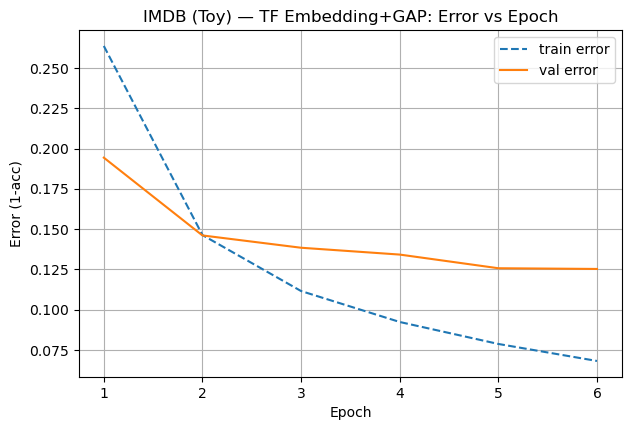

In [52]:
EPOCHS_TF = 6
hist_tf = model.fit(ds_train_vec, validation_data=ds_test_vec, epochs=EPOCHS_TF, verbose=1)

import matplotlib.pyplot as plt
ep = range(1, EPOCHS_TF+1)
train_err = [1 - v for v in hist_tf.history["accuracy"]]
val_err   = [1 - v for v in hist_tf.history["val_accuracy"]]
plt.figure(figsize=(7,4.5))
plt.plot(ep, train_err, "--", label="train error")
plt.plot(ep, val_err,   "-",  label="val error")
plt.title("IMDB (Toy) — TF Embedding+GAP: Error vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("Error (1-acc)"); plt.grid(True); plt.legend(); plt.show()